In [190]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import sys
import copy
import inspect
import warnings
import cProfile

from astropy.table import Table, Column, vstack

import numpy as np 

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Circle
from matplotlib.patches import Polygon as mpl_polygon
from matplotlib.collections import PatchCollection

import palettable
color_fancy = palettable.wesanderson.Mendl_4.mpl_colors
color_bins = palettable.cartocolors.qualitative.Bold_4_r.mpl_colors

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [264]:
from shapely.geometry import Point, MultiPoint, Polygon
from shapely.geometry import asMultiPoint, asPolygon
from shapely.ops import unary_union, cascaded_union
from shapely import wkb

In [191]:
def get_decam_footprints(ra_ini, dec_ini, ra_n=12, dec_n=2, rad=1.1, ra_sep=0.55, dec_sep=2.0):
    """Get the DECam footprints."""
    decam_fps = []
    for ii in np.arange(ra_n):
        for jj in np.arange(dec_n):
            ra = ra_ini + ii * ra_sep
            dec = dec_ini + jj * dec_sep
            decam_fps.append(Circle((ra, dec), rad))
    
    return decam_fps

### Simple version

* Each survey region is represented as a "box" in (RA, Dec)
* Just overplot a few of them together.

#### Footprints of different surveys

* Footprints of GAMA survey comes from [here](http://www.gama-survey.org/)
* Footprints of HSC survey can be found in the [project proposal](https://hsc.mtk.nao.ac.jp/ssp/wp-content/uploads/2016/05/hsc_ssp_rv_jan13.pdf)
* Footprints of KiDS survey can be found [here](http://kids.strw.leidenuniv.nl/overview.php)
* Survey tiles for KiDS can be found [here](http://kids.strw.leidenuniv.nl/DR4/data_table.php)
    - OmegaCAM@VST has a 1x1 deg^2 field of view

#### HSC S19A coverage

* We also use the detailed tract-patch information from S19A to figure out the current HSC coverage. 
* The `s19a_wide_mosaic.fits` catalog is not in public, please contact me.
* We use the `Shapely` library to deal with the geometry of the survey. 
    - `pip install shapely`
* Current HSC coverages in the Spring and Fall fields are estimated for each band.

#### Figure out the S19A HSC coverage

* This is slow, but you only need to do this once; also you can directly use the saved `.npy` files

In [168]:
s19a_mosaic = Table.read('/Users/song/Downloads/s19a_wide_mosaic.fits')

spring_mask = (
    (s19a_mosaic['ra2000'] > 110) & (s19a_mosaic['ra2000'] < 250) & 
    (s19a_mosaic['dec2000'] < 20) & (s19a_mosaic['dec2000'] > -20)
)

fall_mask = (
    ((s19a_mosaic['ra2000'] < 50) | (s19a_mosaic['ra2000'] > 320)) & 
    (s19a_mosaic['dec2000'] < 10) & (s19a_mosaic['dec2000'] > -10)
)

print(spring_mask.sum(), fall_mask.sum())

s19a_g1 = s19a_mosaic[(s19a_mosaic['filter01'] == "HSC-G") & spring_mask]
s19a_g2 = s19a_mosaic[(s19a_mosaic['filter01'] == "HSC-G") & fall_mask]

s19a_r1 = s19a_mosaic[(s19a_mosaic['filter01'] == "HSC-R") & spring_mask]
s19a_r2 = s19a_mosaic[(s19a_mosaic['filter01'] == "HSC-R") & fall_mask]

s19a_i1 = s19a_mosaic[(s19a_mosaic['filter01'] == "HSC-I") & spring_mask]
s19a_i2 = s19a_mosaic[(s19a_mosaic['filter01'] == "HSC-I") & fall_mask]

s19a_z1 = s19a_mosaic[(s19a_mosaic['filter01'] == "HSC-Z") & spring_mask]
s19a_z2 = s19a_mosaic[(s19a_mosaic['filter01'] == "HSC-Z") & fall_mask]

s19a_y1 = s19a_mosaic[(s19a_mosaic['filter01'] == "HSC-Y") & spring_mask]
s19a_y2 = s19a_mosaic[(s19a_mosaic['filter01'] == "HSC-Y") & fall_mask]

print(len(s19a_g1), len(s19a_r1), len(s19a_i1), len(s19a_z1), len(s19a_y1))
print(len(s19a_g2), len(s19a_r2), len(s19a_i2), len(s19a_z2), len(s19a_y2))

117686 79755
22722 22833 24739 23370 24022
17037 18026 13276 17267 14149


In [234]:
s19a_g2['llcra'][(s19a_g2['llcra'] >= 300)] = s19a_g2['llcra'][(s19a_g2['llcra'] >= 300)] - 360.
s19a_g2['urcra'][(s19a_g2['urcra'] >= 300)] = s19a_g2['urcra'][(s19a_g2['urcra'] >= 300)] - 360.
s19a_g2['ulcra'][(s19a_g2['ulcra'] >= 300)] = s19a_g2['ulcra'][(s19a_g2['ulcra'] >= 300)] - 360.
s19a_g2['lrcra'][(s19a_g2['lrcra'] >= 300)] = s19a_g2['lrcra'][(s19a_g2['lrcra'] >= 300)] - 360.

s19a_r2['llcra'][(s19a_r2['llcra'] >= 300)] = s19a_r2['llcra'][(s19a_r2['llcra'] >= 300)] - 360.
s19a_r2['urcra'][(s19a_r2['urcra'] >= 300)] = s19a_r2['urcra'][(s19a_r2['urcra'] >= 300)] - 360.
s19a_r2['ulcra'][(s19a_r2['ulcra'] >= 300)] = s19a_r2['ulcra'][(s19a_r2['ulcra'] >= 300)] - 360.
s19a_r2['lrcra'][(s19a_r2['lrcra'] >= 300)] = s19a_r2['lrcra'][(s19a_r2['lrcra'] >= 300)] - 360.

s19a_i2['llcra'][(s19a_i2['llcra'] >= 300)] = s19a_i2['llcra'][(s19a_i2['llcra'] >= 300)] - 360.
s19a_i2['urcra'][(s19a_i2['urcra'] >= 300)] = s19a_i2['urcra'][(s19a_i2['urcra'] >= 300)] - 360.
s19a_i2['ulcra'][(s19a_i2['ulcra'] >= 300)] = s19a_i2['ulcra'][(s19a_i2['ulcra'] >= 300)] - 360.
s19a_i2['lrcra'][(s19a_i2['lrcra'] >= 300)] = s19a_i2['lrcra'][(s19a_i2['lrcra'] >= 300)] - 360.

s19a_z2['llcra'][(s19a_z2['llcra'] >= 300)] = s19a_z2['llcra'][(s19a_z2['llcra'] >= 300)] - 360.
s19a_z2['urcra'][(s19a_z2['urcra'] >= 300)] = s19a_z2['urcra'][(s19a_z2['urcra'] >= 300)] - 360.
s19a_z2['ulcra'][(s19a_z2['ulcra'] >= 300)] = s19a_z2['ulcra'][(s19a_z2['ulcra'] >= 300)] - 360.
s19a_z2['lrcra'][(s19a_z2['lrcra'] >= 300)] = s19a_z2['lrcra'][(s19a_z2['lrcra'] >= 300)] - 360.

s19a_y2['llcra'][(s19a_y2['llcra'] >= 300)] = s19a_y2['llcra'][(s19a_y2['llcra'] >= 300)] - 360.
s19a_y2['urcra'][(s19a_y2['urcra'] >= 300)] = s19a_y2['urcra'][(s19a_y2['urcra'] >= 300)] - 360.
s19a_y2['ulcra'][(s19a_y2['ulcra'] >= 300)] = s19a_y2['ulcra'][(s19a_y2['ulcra'] >= 300)] - 360.
s19a_y2['lrcra'][(s19a_y2['lrcra'] >= 300)] = s19a_y2['lrcra'][(s19a_y2['lrcra'] >= 300)] - 360.

In [177]:
s19a_g1_poly = cascaded_union(
    [Polygon([(patch['llcra'], patch['llcdec']), (patch['ulcra'], patch['ulcdec']), 
              (patch['urcra'], patch['urcdec']), (patch['lrcra'], patch['lrcdec'])])
     for patch in s19a_g1])

s19a_r1_poly = cascaded_union(
    [Polygon([(patch['llcra'], patch['llcdec']), (patch['ulcra'], patch['ulcdec']), 
              (patch['urcra'], patch['urcdec']), (patch['lrcra'], patch['lrcdec'])])
     for patch in s19a_r1])

s19a_i1_poly = cascaded_union(
    [Polygon([(patch['llcra'], patch['llcdec']), (patch['ulcra'], patch['ulcdec']), 
              (patch['urcra'], patch['urcdec']), (patch['lrcra'], patch['lrcdec'])])
     for patch in s19a_i1])

s19a_z1_poly = cascaded_union(
    [Polygon([(patch['llcra'], patch['llcdec']), (patch['ulcra'], patch['ulcdec']), 
              (patch['urcra'], patch['urcdec']), (patch['lrcra'], patch['lrcdec'])])
     for patch in s19a_z1])

s19a_y1_poly = cascaded_union(
    [Polygon([(patch['llcra'], patch['llcdec']), (patch['ulcra'], patch['ulcdec']), 
              (patch['urcra'], patch['urcdec']), (patch['lrcra'], patch['lrcdec'])])
     for patch in s19a_y1])

In [235]:
s19a_g2_poly = cascaded_union(
    [Polygon([(patch['llcra'], patch['llcdec']), (patch['ulcra'], patch['ulcdec']), 
              (patch['urcra'], patch['urcdec']), (patch['lrcra'], patch['lrcdec'])])
     for patch in s19a_g2])

s19a_r2_poly = cascaded_union(
    [Polygon([(patch['llcra'], patch['llcdec']), (patch['ulcra'], patch['ulcdec']), 
              (patch['urcra'], patch['urcdec']), (patch['lrcra'], patch['lrcdec'])])
     for patch in s19a_r2])

s19a_i2_poly = cascaded_union(
    [Polygon([(patch['llcra'], patch['llcdec']), (patch['ulcra'], patch['ulcdec']), 
              (patch['urcra'], patch['urcdec']), (patch['lrcra'], patch['lrcdec'])])
     for patch in s19a_i2])

s19a_z2_poly = cascaded_union(
    [Polygon([(patch['llcra'], patch['llcdec']), (patch['ulcra'], patch['ulcdec']), 
              (patch['urcra'], patch['urcdec']), (patch['lrcra'], patch['lrcdec'])])
     for patch in s19a_z2])

s19a_y2_poly = cascaded_union(
    [Polygon([(patch['llcra'], patch['llcdec']), (patch['ulcra'], patch['ulcdec']), 
              (patch['urcra'], patch['urcdec']), (patch['lrcra'], patch['lrcdec'])])
     for patch in s19a_y2])

In [250]:
# 1 means the Spring field
# 2 means the Fall field
hsc_g1_reg = np.asarray(list(s19a_g1_poly.exterior.coords))
hsc_g2_reg_a = np.asarray(list(s19a_g2_poly[0].exterior.coords))
hsc_g2_reg_b = np.asarray(list(s19a_g2_poly[1].exterior.coords))

hsc_r1_reg = np.asarray(list(s19a_r1_poly.exterior.coords))
hsc_r2_reg_a = np.asarray(list(s19a_r2_poly[0].exterior.coords))
hsc_r2_reg_b = np.asarray(list(s19a_r2_poly[1].exterior.coords))

hsc_i1_reg = np.asarray(list(s19a_i1_poly.exterior.coords))
hsc_i2_reg_a = np.asarray(list(s19a_i2_poly[0].exterior.coords))
hsc_i2_reg_b = np.asarray(list(s19a_i2_poly[1].exterior.coords))
hsc_i2_reg_c = np.asarray(list(s19a_i2_poly[2].exterior.coords))

hsc_z1_reg = np.asarray(list(s19a_z1_poly.exterior.coords))
hsc_z2_reg_a = np.asarray(list(s19a_z2_poly[0].exterior.coords))
hsc_z2_reg_b = np.asarray(list(s19a_z2_poly[1].exterior.coords))

hsc_y1_reg = np.asarray(list(s19a_y1_poly.exterior.coords))
hsc_y2_reg_a = np.asarray(list(s19a_y2_poly[0].exterior.coords))
hsc_y2_reg_b = np.asarray(list(s19a_y2_poly[1].exterior.coords))
hsc_y2_reg_c = np.asarray(list(s19a_y2_poly[2].exterior.coords))

In [263]:
hsc_footprints = {
    'g1': hsc_g1_reg, 'g2_a': hsc_g2_reg_a, 'g2_b': hsc_g2_reg_b,
    'r1': hsc_r1_reg, 'r2_a': hsc_r2_reg_a, 'r2_b': hsc_r2_reg_b,
    'i1': hsc_i1_reg, 'i2_a': hsc_i2_reg_a, 'i2_b': hsc_i2_reg_b, 'i2_c': hsc_i2_reg_c,
    'z1': hsc_z1_reg, 'z2_a': hsc_z2_reg_a, 'z2_b': hsc_z2_reg_b,
    'y1': hsc_y1_reg, 'y2_a': hsc_y2_reg_a, 'y2_b': hsc_y2_reg_b, 'y2_c': hsc_y2_reg_c,
}

np.save('s19a_spring_fall_footprints.npy', hsc_footprints)

In [257]:
# (RA, Dec) ranges for HSC
# Wide
# HSC spring
hsc_1_arr = np.asarray([[120.5, -3.0], [120.5, 6.0], [227.0, 6.0], [227.0, -3.0]])

# HSC fall
hsc_2_arr = np.asarray([[-31.0, -2.0], [-31.0, 8.0], [42.0, 8.0], [42.0, -7.5], [27.30, -7.5], [27.30, -2.0]])

# HSC Deep fields and UDeep fields
hsc_cosmos = np.asarray([[152.2, 0.8], [152.2, 3.6], [148.6, 3.6], [148.6, 0.8]])
hsc_deep2 = np.asarray([[354.0 - 360.0, -1.2], [354.0 - 360., 1.0], 
                        [350.5 - 360., 1.0], [350.5 - 360., -1.2]])
hsc_xmm = np.asarray([[38.0, -6.0], [38.0, -3.5], [33.8, -3.5], [33.8, -6.0]])

#### GAMA footprints

* Very rough boxes

In [193]:
g02_arr = np.asarray([[30.2, -10.25], [30.2, -3.72], [38.8, -3.72], [38.8, -10.25]])
g09_arr = np.asarray([[129.0, -2.0], [129.0, 3.0], [141.0, 3.0], [141.0, -2.0]])
g12_arr = np.asarray([[174.0, -3.0], [174.0, 2.0], [186.0, 2.0], [186.0, -3.0]])
g15_arr = np.asarray([[211.5, -2.0], [211.5, 3.0], [223.5, 3.0], [223.5, -2.0]])

#### KiDS footprints

* Very rough boxes

In [194]:
kids_n_arr = np.asarray([[156.0, -5.0], [156.0, 4.0], [238.0, 4.0], [238.0, -3.0], [225.0, -3.0], [225.0, -5.0]])
kids_w2_arr = np.asarray([[128.5, -2.0], [128.5, 3.0], [141.5, 3.0], [141.5, -2.0]])
kids_d2_arr = np.asarray([[149.6, 1.7], [149.6, 2.7], [151.6, 2.7], [151.6, 1.7]])

#### Rough footprint of Merian survey

In [390]:
merian_1 = np.asarray([
    [128.0, -2.4], [128.0, 3.2], [142.0, 3.2], [142.0, -2.4]
])

merian_1_poly = Polygon(merian_1)

merian_2 = np.asarray([
    [155.0, -2.4], [155.0, 3.2], [225.0, 3.2], [225.0, -2.4]
])

merian_2_poly = Polygon(merian_2)


print(merian_1_poly.area + merian_2_poly.area)

merian_3 = np.asarray(
    [[153.0, 0.6], [153.0, 3.8], [147.8, 3.8], [147.8, 0.6]])

470.4


In [391]:
merian_4 = np.asarray([
    [-30.0, -1.5], [-30.0, 6.5], [-8.0, 6.5], [-8.0, 2.6],
    [40.0, 2.6], [40.0, -6.5], [28.0, -6.5], [28.0, -1.5]
])

merian_4_poly = Polygon(merian_4)

merian_4_poly.area

432.79999999999995

In [401]:
430 / 36

11.944444444444445

### Generate the plot

* Given the current tiling strategy, we can afford 48 x 12 pointings

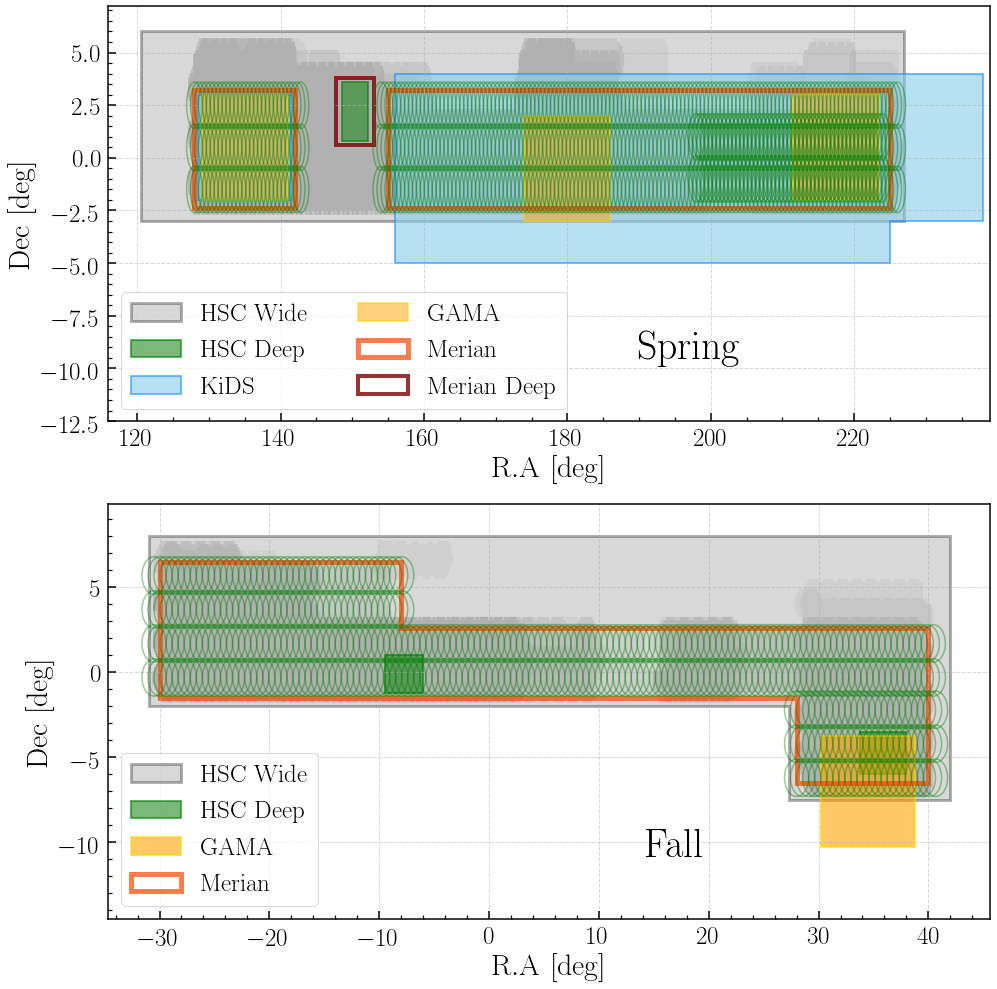

In [400]:
fig = plt.figure(figsize=(14, 15))
fig.subplots_adjust(left=0.12, right=0.995, bottom=0.15, top=0.995, wspace=0.00, hspace=0.2)

# --- Spring Field --- #
ax1 = fig.add_subplot(211)

# HSC Wide
ax1.fill(hsc_1_arr[:, 0], hsc_1_arr[:, 1], facecolor='grey', edgecolor='k', linewidth=3, alpha=0.3,
         label=r'$\rm HSC\ Wide$')

ax1.fill(hsc_g1_reg[:, 0], hsc_g1_reg[:, 1], facecolor='grey', edgecolor='none', linewidth=2, alpha=0.1,
         label='__no_label__', rasterized=True)

ax1.fill(hsc_r1_reg[:, 0], hsc_r1_reg[:, 1], facecolor='grey', edgecolor='none', linewidth=2, alpha=0.1,
         label='__no_label__', rasterized=True)

ax1.fill(hsc_i1_reg[:, 0], hsc_i1_reg[:, 1], facecolor='grey', edgecolor='none', linewidth=2, alpha=0.1,
         label='__no_label__', rasterized=True)

ax1.fill(hsc_z1_reg[:, 0], hsc_z1_reg[:, 1], facecolor='grey', edgecolor='none', linewidth=2, alpha=0.1,
         label='__no_label__', rasterized=True)

ax1.fill(hsc_y1_reg[:, 0], hsc_y1_reg[:, 1], facecolor='grey', edgecolor='none', linewidth=2, alpha=0.1,
         label='__no_label__', rasterized=True)


# HSC Deep
ax1.fill(hsc_cosmos[:, 0], hsc_cosmos[:, 1], facecolor='forestgreen', edgecolor='g', linewidth=2, alpha=0.6,
         label=r'$\rm HSC\ Deep$')

# KiDS
ax1.fill(kids_n_arr[:, 0], kids_n_arr[:, 1], facecolor='skyblue', edgecolor='dodgerblue', linewidth=2, alpha=0.6,
         label=r'$\rm KiDS$')

ax1.fill(kids_w2_arr[:, 0], kids_w2_arr[:, 1], facecolor='skyblue', edgecolor='dodgerblue', linewidth=2, alpha=0.6,
         label='__no_label__')

# GAMA
ax1.fill(g09_arr[:, 0], g09_arr[:, 1], facecolor='orange', edgecolor='gold', linewidth=2, alpha=0.5,
         label=r'$\rm GAMA$')

ax1.fill(g12_arr[:, 0], g12_arr[:, 1], facecolor='orange', edgecolor='gold', linewidth=2, alpha=0.5,
         label='__no_label__')

ax1.fill(g15_arr[:, 0], g15_arr[:, 1], facecolor='orange', edgecolor='gold', linewidth=2, alpha=0.5,
         label='__no_label__')


# Merian survey
ax1.fill(merian_1[:, 0], merian_1[:, 1], facecolor='none', edgecolor='orangered', linewidth=5.0, alpha=0.7,
         label=r'$\rm Merian$')

ax1.fill(merian_2[:, 0], merian_2[:, 1], facecolor='none', edgecolor='orangered', linewidth=5.0, alpha=0.7,
         label='__no_label__')

ax1.fill(merian_3[:, 0], merian_3[:, 1], facecolor='none', edgecolor='maroon', linewidth=4.0, alpha=0.8,
         label=r'\rm Merian\ Deep')

merian1_a = PatchCollection(
    get_decam_footprints(128.0, -1.5, ra_n=28, dec_n=3, rad=1.1, ra_sep=0.55, dec_sep=2.0),
    alpha=0.4, facecolor='none', edgecolor='g', linewidth=1.5, zorder=100 
)

merian1_b = PatchCollection(
    get_decam_footprints(154.0, -1.5, ra_n=(44 * 3), dec_n=3, rad=1.1, ra_sep=0.55, dec_sep=2.0),
    alpha=0.4, facecolor='none', edgecolor='g', linewidth=1.5, zorder=100 
)

merian1_c = PatchCollection(
    get_decam_footprints(198.0, -1.0, ra_n=48, dec_n=2, rad=1.1, ra_sep=0.55, dec_sep=2.0),
    alpha=0.4, facecolor='none', edgecolor='g', linewidth=1.5, zorder=100 
)

ax1.add_collection(merian1_a)
ax1.add_collection(merian1_b)
ax1.add_collection(merian1_c)

ax1.set_ylim(-12.5, 7.2)
ax1.set_xlim(116, 239)

ax1.text(0.60, 0.15, r'$\rm Spring$', fontsize=40, transform=ax1.transAxes)

ax1.legend(loc='lower left', fontsize=25, ncol=2)

_ = ax1.set_xlabel(r'$\rm R.A\ [deg]$', fontsize=30)
_ = ax1.set_ylabel(r'$\rm Dec\ [deg]$', fontsize=30)

# --- Fall Fields --- #
ax2 = fig.add_subplot(212)

# HSC Wide
ax2.fill(hsc_2_arr[:, 0], hsc_2_arr[:, 1], facecolor='grey', edgecolor='k', linewidth=3, alpha=0.3,
         label=r'$\rm HSC\ Wide$')

ax2.fill(hsc_g2_reg_a[:, 0], hsc_g2_reg_a[:, 1], facecolor='grey', edgecolor='none', linewidth=2, alpha=0.1, 
         label='__no_label__', rasterized=True)
ax2.fill(hsc_g2_reg_b[:, 0], hsc_g2_reg_b[:, 1], facecolor='grey', edgecolor='none', linewidth=2, alpha=0.1, 
         label='__no_label__', rasterized=True)

ax2.fill(hsc_r2_reg_a[:, 0], hsc_r2_reg_a[:, 1], facecolor='grey', edgecolor='none', linewidth=2, alpha=0.1, 
         label='__no_label__', rasterized=True)
ax2.fill(hsc_r2_reg_b[:, 0], hsc_r2_reg_b[:, 1], facecolor='grey', edgecolor='none', linewidth=2, alpha=0.1, 
         label='__no_label__', rasterized=True)

ax2.fill(hsc_i2_reg_a[:, 0], hsc_i2_reg_a[:, 1], facecolor='grey', edgecolor='none', linewidth=2, alpha=0.1, 
         label='__no_label__', rasterized=True)
ax2.fill(hsc_i2_reg_b[:, 0], hsc_i2_reg_b[:, 1], facecolor='grey', edgecolor='none', linewidth=2, alpha=0.1, 
         label='__no_label__', rasterized=True)
ax2.fill(hsc_i2_reg_c[:, 0], hsc_i2_reg_c[:, 1], facecolor='grey', edgecolor='none', linewidth=2, alpha=0.1, 
         label='__no_label__', rasterized=True)

ax2.fill(hsc_z2_reg_a[:, 0], hsc_z2_reg_a[:, 1], facecolor='grey', edgecolor='none', linewidth=2, alpha=0.1, 
         label='__no_label__', rasterized=True)
ax2.fill(hsc_z2_reg_b[:, 0], hsc_z2_reg_b[:, 1], facecolor='grey', edgecolor='none', linewidth=2, alpha=0.1, 
         label='__no_label__', rasterized=True)

ax2.fill(hsc_y2_reg_a[:, 0], hsc_y2_reg_a[:, 1], facecolor='grey', edgecolor='none', linewidth=2, alpha=0.1, 
         label='__no_label__', rasterized=True)
ax2.fill(hsc_y2_reg_b[:, 0], hsc_y2_reg_b[:, 1], facecolor='grey', edgecolor='none', linewidth=2, alpha=0.1, 
         label='__no_label__', rasterized=True)
ax2.fill(hsc_y2_reg_c[:, 0], hsc_y2_reg_c[:, 1], facecolor='grey', edgecolor='none', linewidth=2, alpha=0.1, 
         label='__no_label__', rasterized=True)


# HSC Deep
ax2.fill(hsc_deep2[:, 0], hsc_deep2[:, 1], facecolor='forestgreen', edgecolor='g', linewidth=2, alpha=0.6,
         label=r'$\rm HSC\ Deep$')

ax2.fill(hsc_xmm[:, 0], hsc_xmm[:, 1], facecolor='forestgreen', edgecolor='g', linewidth=2, alpha=0.6,
         label='__no_label__')

# GAMA
ax2.fill(g02_arr[:, 0], g02_arr[:, 1], facecolor='orange', edgecolor='gold', linewidth=2, alpha=0.6,
         label=r'$\rm GAMA$')

# Merian
ax2.fill(merian_4[:, 0], merian_4[:, 1], facecolor='none', edgecolor='orangered', linewidth=5.0, alpha=0.7,
         label=r'$\rm Merian$')


merian2_a = PatchCollection(
    get_decam_footprints(-30.5, -0.3, ra_n=130, dec_n=2, rad=1.1, ra_sep=0.55, dec_sep=2.0),
    alpha=0.4, facecolor='none', edgecolor='g', linewidth=1.5, zorder=100 
)

merian2_b = PatchCollection(
    get_decam_footprints(-30.5, -0.3 + (2.0 * 2), ra_n=42, dec_n=2, rad=1.1, ra_sep=0.55, dec_sep=2.0),
    alpha=0.4, facecolor='none', edgecolor='g', linewidth=1.5, zorder=100 
)

merian2_c = PatchCollection(
    get_decam_footprints(28.0, -6.2, ra_n=24, dec_n=3, rad=1.1, ra_sep=0.55, dec_sep=2.0),
    alpha=0.4, facecolor='none', edgecolor='g', linewidth=1.5, zorder=100 
)

ax2.add_collection(merian2_a)
ax2.add_collection(merian2_b)
ax2.add_collection(merian2_c)

ax2.legend(loc='lower left', fontsize=25)

ax2.set_ylim(-14.5, 9.9)

ax2.text(0.61, 0.15, r'$\rm Fall$', fontsize=40, transform=ax2.transAxes)

_ = ax2.set_xlabel(r'$\rm R.A\ [deg]$', fontsize=30)
_ = ax2.set_ylabel(r'$\rm Dec\ [deg]$', fontsize=30)

### Using `Mangle` Polygon format

* [The `mangle` software can be found here](https://github.com/mollyswanson/mangle)
    - There is an old Python wrapper ['mangle.py'](https://github.com/mollyswanson/manglepy)
* ['pymangle' by Erin Sheldon can read in and work with `Mangle` masks](https://github.com/esheldon/pymangle)
* [Survey footprints of several wide field surveys can be found here](http://www.mpe.mpg.de/~tdwelly/erosita/multiwavelength_coverage)

In [4]:
import pymangle

In [5]:
m=pymangle.Mangle("data/boss_survey.ply")

In [7]:
m.pixelres

-1